## CCE BIN Clock Calibrations
*Run programs to compare real time clock with BIN system time and with instrument clocks - Mike McCann 12 May 2016*

The Python programs used to get data into formats to be read into this Notebook are in MBARI's CVS on moonjelly: http://moonjelly.shore.mbari.org/cgi-bin/cvsweb.cgi/DPforSSDS/py/ (they have also been copied to the CCE_Processed/Software/ssds directory). They were executed thusly:

```
cd /u/ssdsadmin/dev/DPforSSDS/py
./bin_clocks_parse.py > /mbari/CCE_Processed/BIN/20151013/clocks/bin_sys_rtc_clocks.csv

./ssds_adcp_extract.py --timestamps --stride 10000 --device_id 1825 \
    > /mbari/CCE_Processed/BIN/20151013/clocks/adcp_1825_clocks.csv
./ssds_adcp_extract.py --timestamps --stride 10000 --device_id 1827 \
    > /mbari/CCE_Processed/BIN/20151013/clocks/adcp_1827_clocks.csv
./ssds_adcp_extract.py --timestamps --stride 10000 --device_id 1828 \
    > /mbari/CCE_Processed/BIN/20151013/clocks/adcp_1828_clocks.csv
```
To execute this Notebook mount the cifs://atlas.shore.mbari.org/cce_processed share on your compter and cd to the BIN/20151013/clocks directory (e.g. on a Mac that would be `cd /Volumes/CCE_Processed/BIN/20151013/clocks`) and then execute the `jupyter notebook` command in a terminal window. This assumes that you have Anaconda2 (or equivalent) installed on your computer.

### Examine the real time clock and BIN contoller system clock
Read the csv file into a Pandas data frame and show the first 10 records

In [1]:
import pandas as pd
df = pd.read_csv('bin_sys_rtc_clocks.csv', parse_dates=True, index_col='realtimeclock_datetime')
df.head()

system_datetime  realtimeclock_epoch_seconds  \
realtimeclock_datetime                                                     
2015-10-10 18:44:12     2015-10-10 18:44:11                   1444502652   
2015-10-10 19:44:11     2015-10-10 19:44:11                   1444506251   
2015-10-10 20:44:11     2015-10-10 20:44:11                   1444509851   
2015-10-10 21:44:11     2015-10-10 21:44:12                   1444513451   
2015-10-10 22:44:11     2015-10-10 22:44:12                   1444517051   

                        system_epoch_seconds datetime_difference  \
realtimeclock_datetime                                             
2015-10-10 18:44:12               1444502651     -1 day 23:59:59   
2015-10-10 19:44:11               1444506251             0:00:00   
2015-10-10 20:44:11               1444509851             0:00:00   
2015-10-10 21:44:11               1444513452             0:00:01   
2015-10-10 22:44:11               1444517052             0:00:01   

                        seconds_difference  
realtimeclock_datetime                      
2015-10-10 18:44:12                     -1  
2015-10-10 19:44:11                      0  
2015-10-10 20:44:11                      0  
2015-10-10 21:44:11                      1  
2015-10-10 22:44:11                      1

Plot over time the seconds difference between the real time clock and the system clock

In [2]:
%matplotlib inline
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.resources import INLINE
output_notebook(resources=INLINE, hide_banner=True)
p = figure(title="BIN Controller Clock Time Difference with Real Time Clock",
           width=900, height=300,
           x_axis_type='datetime',
           x_axis_label='RTC Time (GMT)', 
           y_axis_label='seconds_difference')
p.line(df.index, df.seconds_difference, line_width=1)
_ = show(p)

### Examine the ADCP clocks compared to the BIN controller clock
Read the csv files created by the `ssds_adcp_extract.py` script into Pandas data frames and make a common index name

In [3]:
%pdb on
df_1825 = pd.read_csv('adcp_1825_clocks.csv', parse_dates=True, index_col='1825_siam_datetime')
df_1827 = pd.read_csv('adcp_1827_clocks.csv', parse_dates=True, index_col='1827_siam_datetime')
df_1828 = pd.read_csv('adcp_1828_clocks.csv', parse_dates=True, index_col='1828_siam_datetime')
df_1825.index.names = ['siam_datetime']
df_1827.index.names = ['siam_datetime']
df_1828.index.names = ['siam_datetime']
import pdb; pdb.set_trace()

Automatic pdb calling has been turned ON
--Call--
> /Users/mccann/anaconda/lib/python3.6/site-packages/IPython/core/displayhook.py(247)__call__()
-> def __call__(self, result=None):
(Pdb) c


The ~7 hour time difference indicates that the ADCPs were set to local time. Join the data together and plot the clock drifts on the same figure.

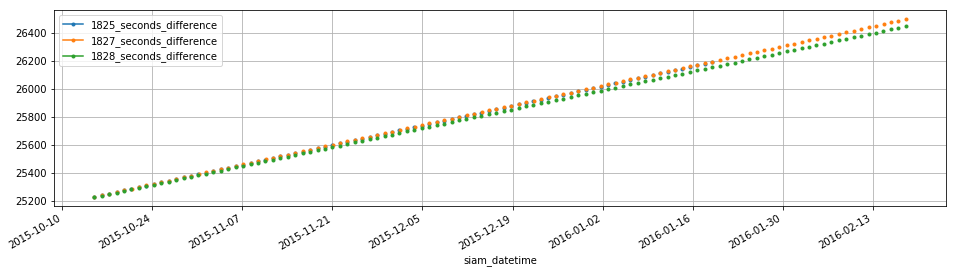

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 4)
df_adcp = df_1825.join(df_1827, how='outer').join(df_1828, how='outer')
dfp = df_adcp[['1825_seconds_difference', '1827_seconds_difference', '1828_seconds_difference']]
dfp.plot(marker='.', grid=True)

The SIAM system clock drifted about 1200 seconds relative to all the ADCP instrument clocks.

### Calculate SIAM system to real time clock regression

Define function that returns slope and intercept of linear fit through data

In [5]:
import statsmodels.api as sm
def linear_fit(X, y):
    'Return slope, intercept, and y_hat predicted values'
    model = sm.OLS(y, sm.add_constant(X))
    results = model.fit()
    intercept, slope = results.params
    print(('slope = {}, intercept = {}').format(slope, intercept))
    y_hat = results.predict(sm.add_constant(X))
    return slope, intercept, y_hat

Examination of the rows of `df` reveals that 2016-02-18 19:19:47 is the last time before the BIN started rebooting, pull those data out for the regression. Make a copy of that subset and compute a linear least-squares fit of system (SIAM) clock to real time clock for the time period we have ADCP data in SSDS.

In [6]:
df_subset = df.loc[:'2016-02-18 19:19:47'].copy()
X = df_subset.system_epoch_seconds
y = df_subset.realtimeclock_epoch_seconds
siam2rtc_slope, siam2rtc_intercept, siam2rtc_y_hat = linear_fit(X, y)

slope = 0.9998829642354998, intercept = 169079.89974352717


The equation:

__corrected_time = 0.999882964235 * siam_clock + 169079.899744__

Applies to siam times where there is a slope in the BIN Controller Clock Time Difference with Real Time Clock plot. Let's lis the records at the boundaries of the period of system rebooting to get the siam clock times between which no correction is needed.

In [7]:
df.loc['2016-02-18 17:00':'2016-02-18 20:40']

system_datetime  realtimeclock_epoch_seconds  \
realtimeclock_datetime                                                     
2016-02-18 17:19:48     2016-02-18 17:41:31                   1455815988   
2016-02-18 18:19:48     2016-02-18 18:41:32                   1455819588   
2016-02-18 19:19:47     2016-02-18 19:41:32                   1455823187   
2016-02-18 20:19:50     2016-02-18 20:19:50                   1455826790   
2016-02-18 20:28:08     2016-02-18 20:28:08                   1455827288   
2016-02-18 20:36:13     2016-02-18 20:36:13                   1455827773   

                        system_epoch_seconds datetime_difference  \
realtimeclock_datetime                                             
2016-02-18 17:19:48               1455817291             0:21:43   
2016-02-18 18:19:48               1455820892             0:21:44   
2016-02-18 19:19:47               1455824492             0:21:45   
2016-02-18 20:19:50               1455826790             0:00:00   
2016-02-18 20:28:08               1455827288             0:00:00   
2016-02-18 20:36:13               1455827773             0:00:00   

                        seconds_difference  
realtimeclock_datetime                      
2016-02-18 17:19:48                   1303  
2016-02-18 18:19:48                   1304  
2016-02-18 19:19:47                   1305  
2016-02-18 20:19:50                      0  
2016-02-18 20:28:08                      0  
2016-02-18 20:36:13                      0

In [8]:
df.loc['2016-02-29 18:45':'2016-02-29 23:40']

system_datetime  realtimeclock_epoch_seconds  \
realtimeclock_datetime                                                     
2016-02-29 18:48:55     2016-02-29 18:48:55                   1456771735   
2016-02-29 18:57:47     2016-02-29 18:57:47                   1456772267   
2016-02-29 19:57:47     2016-02-29 19:57:47                   1456775867   
2016-02-29 20:57:46     2016-02-29 20:57:47                   1456779466   
2016-02-29 21:57:46     2016-02-29 21:57:48                   1456783066   
2016-02-29 22:57:46     2016-02-29 22:57:48                   1456786666   

                        system_epoch_seconds datetime_difference  \
realtimeclock_datetime                                             
2016-02-29 18:48:55               1456771735             0:00:00   
2016-02-29 18:57:47               1456772267             0:00:00   
2016-02-29 19:57:47               1456775867             0:00:00   
2016-02-29 20:57:46               1456779467             0:00:01   
2016-02-29 21:57:46               1456783068             0:00:02   
2016-02-29 22:57:46               1456786668             0:00:02   

                        seconds_difference  
realtimeclock_datetime                      
2016-02-29 18:48:55                      0  
2016-02-29 18:57:47                      0  
2016-02-29 19:57:47                      0  
2016-02-29 20:57:46                      1  
2016-02-29 21:57:46                      2  
2016-02-29 22:57:46                      2

The equation:

__corrected_time = 0.999882964235 * siam_clock + 169079.899744__

Applies to siam times approximately before 2016-02-18 20:19:50 (system_epoch_seconds = 1455826790) and after 2016-02-29 19:57:47 (system_epoch_seconds = 1456779467). In between these times the system continually rebooted with less than 2 second difference from the real time clock.

### Find the exact time of the system rebooting period

Extract a .csv file from SSDS for a few day period around the start of the time when the system started rebooting:

    ssds_ctd_extract.py --device_id 1533 --csv --start 20160218T000000 --end 20160220T000000 > ctd.csv

Load that file into a Pandas dataframe and plot the diff of datetime to find the exact time of the first system reboot

In [9]:
df_ctd = pd.read_csv('ctd.csv', parse_dates=True, index_col='datetime_gmt')
p = figure(title="CTD Time Around Start of System Reboots",
           width=900, height=300,
           x_axis_type='datetime',
           x_axis_label='SIAM Time', 
           y_axis_label='datetime_es.diff (sec)')
p.line(df_ctd.index, df_ctd.datetime_es.diff(), line_width=1)
_ = show(p)

Examine the rows of data at the time of first reboot

In [10]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)
df_ctd['datetime_es_diff'] = df_ctd.datetime_es.diff()
df_ctd.loc['2016-02-18 20:41:45':'2016-02-18 20:43:00']

datetime_es  temperature  conductivity  pressure  \
datetime_gmt                                                                   
2016-02-18 20:41:45.337200 1455828105.3          2.2           2.4    1860.7   
2016-02-18 20:41:47.338100 1455828107.3          2.2           2.4    1860.7   
2016-02-18 20:41:49.339000 1455828109.3          2.2           2.4    1860.6   
2016-02-18 20:42:11.581200 1455828131.6          2.2           2.4    1860.6   
2016-02-18 20:42:33.823400 1455828153.8          2.2           2.4    1860.7   
2016-02-18 20:42:56.065600 1455828176.1          2.2           2.4    1860.7   

                            TransmissivityVoltage  OBSVoltage  Voltage2  \
datetime_gmt                                                              
2016-02-18 20:41:45.337200                    0.2         0.0       0.0   
2016-02-18 20:41:47.338100                    0.2         0.0       0.0   
2016-02-18 20:41:49.339000                    0.2         0.0       0.0   
2016-02-18 20:42:11.581200                    0.2         0.0       0.0   
2016-02-18 20:42:33.823400                    0.2         0.0       0.0   
2016-02-18 20:42:56.065600                    0.2         0.0       0.0   

                            Voltage3  datetime_es_diff  
datetime_gmt                                            
2016-02-18 20:41:45.337200       0.0               2.0  
2016-02-18 20:41:47.338100       0.0               2.0  
2016-02-18 20:41:49.339000       0.0               2.0  
2016-02-18 20:42:11.581200       0.0              22.2  
2016-02-18 20:42:33.823400       0.0              22.2  
2016-02-18 20:42:56.065600       0.0              22.2

Any SIAM time greater than 2016-02-18 20:42:11.581200 (datetime_es = 1455828131) and less than 2016-02-29 19:57:47 (system_epoch_seconds = 1456779467) is essentially the same as the real time clock time.

### Examine the error

Add the predicted time and the difference from observed to the data frame

In [11]:
df_subset['y_hat'] = siam2rtc_y_hat
df_subset['error'] = df_subset.realtimeclock_epoch_seconds - df_subset.y_hat

Plot the error of the predicted value to confirm the functioning of the algorithm and the quality of the fit

In [12]:
p = figure(title="Predicted Real Time Clock Error",
           width=900, height=300,
           x_axis_type='datetime',
           x_axis_label='RTC Time (GMT)', 
           y_axis_label='error (seconds)')
p.line(df_subset.index, df_subset.error, line_width=1)
_ = show(p)

In [13]:
# Spot check
df_subset.system_epoch_seconds[900] * siam2rtc_slope + siam2rtc_intercept, df_subset.realtimeclock_epoch_seconds[900]

(1447741558.3178055, 1447741559)

### Calculate ADCP instrument to real time clock lookup, via the SIAM system clock

Compute slope and intercepts of the regression of ADCP clocks onto the SIAM system clock

In [14]:
adcp1825siam_slope, adcp1825siam_intercept, _ = linear_fit(
                    df_adcp['1825_instrument_epoch_seconds'].dropna(),
                    df_adcp['1825_siam_epoch_seconds'].dropna())
adcp1827siam_slope, adcp1827siam_intercept, _ = linear_fit(
                    df_adcp['1827_instrument_epoch_seconds'].dropna(),
                    df_adcp['1827_siam_epoch_seconds'].dropna())
adcp1828siam_slope, adcp1828siam_intercept, _ = linear_fit(
                    df_adcp['1828_instrument_epoch_seconds'].dropna(),
                    df_adcp['1828_siam_epoch_seconds'].dropna())

slope = 1.0001162683588785, intercept = -142762.3787498474
slope = 1.0001166019809318, intercept = -143243.41762542725
slope = 1.0001121839147282, intercept = -136863.10041093826


Equation to convert ADCP clock to real time clock time is:

    rtc = siam2rtc_slope * (adcp2siam_slope * adcp_clock + adcp2siam_intercept) + siam2rtc_intercept
    
Compute slope and intercept for each ADCP clock conversion to real time clock

In [15]:
adcp1825rtc_slope = siam2rtc_slope * adcp1825siam_slope
adcp1825rtc_intercept = siam2rtc_slope * adcp1825siam_intercept + siam2rtc_intercept
print(('ADCP 1825 -  300 KHz: slope = {:.10f}, intercept = {:.6f}').format(
            adcp1825rtc_slope, adcp1825rtc_intercept))
adcp1827rtc_slope = siam2rtc_slope * adcp1827siam_slope
adcp1827rtc_intercept = siam2rtc_slope * adcp1827siam_intercept + siam2rtc_intercept
print(('ADCP 1827 - 1200 KHz: slope = {:.10f}, intercept = {:.6f}').format(
            adcp1827rtc_slope, adcp1827rtc_intercept))
adcp1828rtc_slope = siam2rtc_slope * adcp1828siam_slope
adcp1828rtc_intercept = siam2rtc_slope * adcp1828siam_intercept + siam2rtc_intercept
print(('ADCP 1828 -  600 KHz: slope = {:.10f}, intercept = {:.6f}').format(
            adcp1828rtc_slope, adcp1828rtc_intercept))

ADCP 1825 -  300 KHz: slope = 0.9999992190, intercept = 26334.229298
ADCP 1827 - 1200 KHz: slope = 0.9999995526, intercept = 25853.246721
ADCP 1828 -  600 KHz: slope = 0.9999951350, intercept = 32232.817210
